<a href="https://colab.research.google.com/github/GarzonDiegoINL/Characterization/blob/main/Solar_Cells_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Solar cells analysis
To analyse solar cells data from the solar simulator files.

Save your files with the format "Sample name_Results Table/IV Graph XX.txt"
Underscore after sample name is a must as well as the type of data, if it is the results table or the IV curves.

Upload the txt files. In order to upload, click the folder button in the left of the screen and click the upload button (first button), and select the respective files. For example:

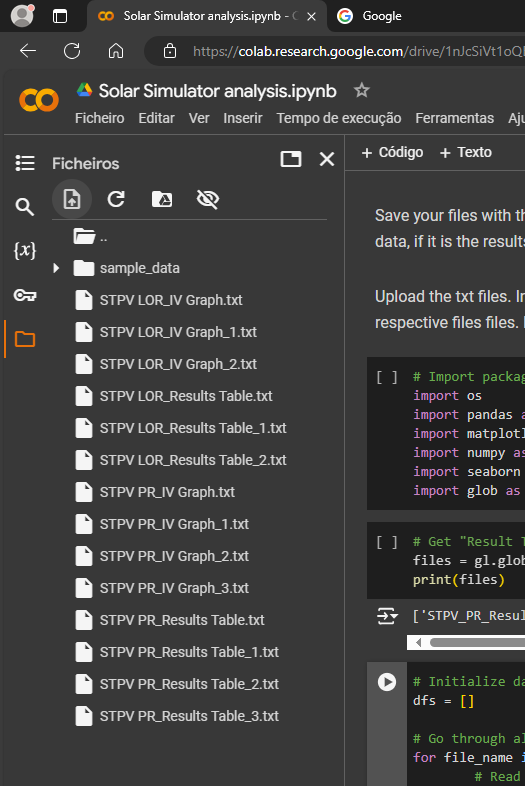

# Packages

In [17]:
# Import packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob as gl
import re, fnmatch

#Temperature of measurement
T = 25 #C

# Functions

In [18]:
#Constants values
k = 1.380649e-23 #J/K
T += 273.15 #K
q = 1.602176634e-19 #C

Vt = k*T/q

dict_colors = None


def find_files(glob_pat, path = os.getcwd(), ignore_case = True):
  rule = re.compile(fnmatch.translate(glob_pat), re.IGNORECASE) if ignore_case \
    else re.compile(fnmatch.translate(glob_pat))
  return [n for n in gl.glob(os.path.join(path, '*')) if rule.match(n)]

# Delete short circuit cells and calculates areas and resistances. Input: Results Table files. Output: Data frame of results with additional parameters.
def filter_results_tables(files):
      dfs = [] # Initialize data frame variable
      for file_name in files: # Go through all files
            current_df = pd.read_csv(os.path.join(file_name), sep='\t') # Read file
            current_df['Filename'] = file_name # Add a new column 'Filename' and set its value to the current file name
            current_df['Sample'] = file_name.split("Results Table", 1)[0].split("/")[-1].strip() # Add a new column 'Sample' and set its value to the sample name
            dfs.append(current_df) # Append the current data frame to the list
      result_df = pd.concat(dfs, ignore_index=True) # Concatenate all dataframes in the list into a single data frame

      result_df = result_df[result_df['Jsc mA/cm2']<40] # Remove cells short circuted (Jsc above 40 mA/cm2)
      result_df = result_df[result_df['Fill Factor'] < 80] #Remove cells with too high FF
      result_df['Area cm2'] = (result_df['Isc A'] / result_df['Jsc mA/cm2'])*10**3 # Add a new column 'Area cm2' and set it with the areas values
      result_df['Rseriescm2']=result_df['R at Voc']*result_df['Area cm2'] # Add a new column 'Rseriescm2' and set it with the series resistance values
      result_df['Rshuntcm2']=result_df['R at Isc']*result_df['Area cm2'] # Add a new column 'Rshuntcm2' and set it with the shunt resistance values

      #Dataframes to store the results
      df_eff = pd.DataFrame()
      df_v = pd.DataFrame()
      df_j = pd.DataFrame()
      df_f = pd.DataFrame()
      df_rs = pd.DataFrame()
      df_rh = pd.DataFrame()


      units = ['%', 'V', 'mA/cm2', '%', 'Ohm cm2', 'Ohm cm2']

      #Fill in the dataframes
      for sample in result_df.Sample.unique():
        for df, col, uni in zip([df_eff, df_v, df_j, df_f, df_rs, df_rh],
                                ['Efficiency', 'Voc V', 'Jsc mA/cm2', 'Fill Factor', 'Rseriescm2', 'Rshuntcm2'],
                                units):
          df[sample + ' ' + uni] = result_df.loc[result_df.Sample == sample, col]

      #Fill in the excel file, with one sheet for each parameter
      with pd.ExcelWriter('Boxplot output_results.xlsx') as writer:
        for df, col in zip([df_eff, df_v, df_j, df_f, df_rs, df_rh], ['Efficiency', 'Voc', 'Jsc', 'Fill Factor', 'Rseries', 'Rshunt']):
          df.to_excel(writer, sheet_name=col)


      #Export the processed data from the results table
      with pd.ExcelWriter('Processed data from Results table.xlsx') as writer:
        result_df.to_excel(writer, sheet_name='all data')
        for sample in result_df.Sample.unique():
          result_df[result_df.Sample == sample].to_excel(writer, sheet_name=sample)

      return result_df



# Draw box plots of main solar cells parameters. Input: Results data frame.
def draw_boxplots(results, order_samples=None):

      samples_order = results.Sample.unique()

      if order_samples is None:

        order_samples = np.flip(samples_order)
        print(order_samples)

      n_colors = np.shape(samples_order)[0]
      palette_colors = sns.color_palette("colorblind", n_colors)
      dict_colors = {x:y for x,y in zip(samples_order, palette_colors)}

      figure, axs = plt.subplots(2,3, figsize=(7.5*len(results['Sample'].value_counts()),10)) # Create figure
      figure.tight_layout(pad=2) # Set space between subplots
      # Draw boxplots for each parameter
      for ax, label, yy  in zip(axs.flatten(), ['Voc V','Jsc mA/cm2','Efficiency','Fill Factor','Rseriescm2','Rshuntcm2'], ['V$_{oc}$ (V)','J$_{sc}$ (mA/cm$^2$)','PCE (%)','FF (%)','R$_{\mathrm{s}}$ (Ω.cm$^2$)','R$_{\mathrm{sh}}$ (Ω.cm$^2$)']):
            sns.boxplot(data=results, x='Sample', y=label, hue='Sample', order=order_samples, palette=palette_colors, ax=ax, legend=False, widths = 0.6, showfliers=False)
            sns.stripplot(data=results,x='Sample',y=label,order=order_samples,ax=ax,size=7,jitter=True,linewidth=1,facecolors='orange',edgecolor='black',)
            ax.set_ylabel(yy, fontsize="12")
            plt.xlabel('Sample')

      plt.savefig('boxplots.png', bbox_inches='tight', pad_inches=0.2) # Save boxplot image
      plt.show()

      return dict_colors

def num_of_zeros(n):
  s = '{:.16f}'.format(n).split('.')
  if s[0] == '0':
    return len(s[1]) - len(s[1].lstrip('0')) + 1
  else:
    return 0

def get_text(data_):
  df = pd.DataFrame()
  for sample in data_.index:

    data = data_.loc[sample]

    for col in ['Efficiency', 'Voc V', 'Jsc mA/cm2', 'Fill Factor', 'Rseriescm2', 'Rshuntcm2']:
      dec = data.loc[col, 'decimals']
      fmt = data.loc[col, 'fmt']
      men = data.loc[col, 'mean'].round(dec)
      std = data.loc[col, 'std'].round(dec)
      df.loc[data.name, col] = fmt.format(men, std)

  return df

# Calculate mean values for each sample and print them. Input: Results data frame.
def calc_mean_values(results, less_decimals=True):
      new_results = results[np.append(results.select_dtypes(include='number').columns.values, 'Sample')].groupby('Sample').agg(['mean', 'std'])

      if less_decimals:
        for col in ['Efficiency', 'Voc V', 'Jsc mA/cm2', 'Fill Factor', 'Rseriescm2', 'Rshuntcm2']:
          new_results[col, 'decimals'] = new_results.apply(lambda x: num_of_zeros(x[col, 'std']) , axis=1)
          new_results[col, 'fmt'] = new_results.apply(lambda x:'{0:.' + str(int(x[col, 'decimals'])) + 'f} $\pm$ {1:.' + str(int(x[col, 'decimals'])) + 'f}', axis=1)

        df = get_text(new_results)

      else:
        df = pd.DataFrame()
        for col in ['Efficiency', 'Jsc mA/cm2', 'Fill Factor', 'Rseriescm2', 'Rshuntcm2']:
          df[col] = new_results.apply(lambda x: '{0:.2f} $\pm$ {1:.2f}'.format(x[col, 'mean'], x[col, 'std']), axis=1)

        df['Voc V'] = new_results.apply(lambda x: '{0:.4f} $\pm$ {1:.4f}'.format(x['Voc V', 'mean'], x['Voc V', 'std']), axis=1)

      df['Sample'] = new_results.index
      print("Average values per sample:")

      row_labels = create_table(df, True)
      return row_labels


# Print parameters values of cell with best Voc for each sample. Input: Results data frame. Output: Best cells data frame.
def get_best_cell(results, parameter):
      Bdf = pd.DataFrame() # Initialize data frame
      max_voc_indices = results.groupby('Sample')[parameter].idxmax() # Get index of best cells
      Bdf['Sample'] = results.loc[max_voc_indices, 'Sample'] # Get parameters of best cells
      Bdf['Measurement'] = results.loc[max_voc_indices, 'Measurement']
      Bdf['Area cm2'] = results.loc[max_voc_indices, 'Area cm2']
      Bdf['Efficiency'] = results.loc[max_voc_indices, 'Efficiency']
      Bdf['Voc V'] = results.loc[max_voc_indices, 'Voc V']
      Bdf['Jsc mA/cm2'] = results.loc[max_voc_indices, 'Jsc mA/cm2']
      Bdf['Fill Factor'] = results.loc[max_voc_indices, 'Fill Factor']
      Bdf['Rseriescm2'] = results.loc[max_voc_indices, 'Rseriescm2']
      Bdf['Rshuntcm2'] = results.loc[max_voc_indices, 'Rshuntcm2']

      # Print parameters of best cell for each sample
      if parameter == 'Voc V':
        print("Cells with best Voc for each sample:")
      else:
        print("Cells with best PCE for each sample:")

      create_table(Bdf)

      return Bdf


def create_table(bdf, average=False):
      row_labels =  bdf.Sample.values
      if average:

        col_labels = ['PCE (%)', 'V$_{oc}$ (V)', 'J$_{sc}$ (mA $cm^{-2}$)', 'FF (%)', 'Rs (Ω.cm$^2$)', 'Rsh (Ω.cm$^2$)']
        data_table = bdf[['Efficiency', 'Voc V', 'Jsc mA/cm2', 'Fill Factor', 'Rseriescm2', 'Rshuntcm2']].values

      else:

        col_labels = ['Measurement', 'PCE (%)', 'V$_{oc}$ (V)', 'J$_{sc}$ (mA $cm^{-2}$)', 'FF (%)', 'Rs (Ω.cm$^2$)', 'Rsh (Ω.cm$^2$)']
        data_table = bdf[['Measurement', 'Efficiency', 'Voc V', 'Jsc mA/cm2', 'Fill Factor', 'Rseriescm2', 'Rshuntcm2']].values

        for i in range(len(data_table)):
          data_table[i, 0] = re.split(' \d{2,4}\-\d{1,2}\-\d{1,2}', data_table[i, 0])[0]
          data_table[i, 2] = '{0:.4f}'.format(data_table[i, 2])
          for idx in [1, 3, 4, 5, 6]:
            data_table[i ,idx] = '{0:.2f}'.format(data_table[i, idx])


      plt.figure(figsize=(9, len(row_labels) * 2/3))
      plt.table(data_table, rowLabels = row_labels, colLabels=col_labels,
                bbox=(0, 0, 1, 1), fontsize=30, cellLoc='center')

      plt.gca().axis('off')
      plt.show()

      return row_labels


# Read IV Graph files into a data frame. Input: IV Graph files. Output: Data frame of IV data.
def read_IV_files(files):
      dfs = pd.DataFrame() # Initialize data frame
      for file_name in files: # Go through all files
            df = pd.read_csv(file_name, delimiter='\t') # Read the CSV file into a data frame
            dfs = pd.concat([dfs,df],axis=1) # Concatenate current data frame into main one by columns
      return dfs

# Plot JV data of specific cells. Input: IV data frame, list of cells name, list of area values of cells.
def plot_JVs(data,Bdf,parameter, dict_colors=dict_colors):

      if isinstance(dict_colors, dict) == False:
          dict_colors = {x:y for x, y in zip(Bdf.Sample.values, sns.color_palette("colorblind", np.shape(Bdf.Sample.values)[0]))}

      xx = [] # Initialize list for voltage values
      yy = [] # Initialize list for current density values
      cc = [] # Initialize list for color values
      # Go through cells
      for s,target_column,a,e,v,j,f,rs,rsh  in zip(Bdf['Sample'], Bdf['Measurement'], Bdf['Area cm2'], Bdf['Efficiency'], Bdf['Voc V'], Bdf['Jsc mA/cm2'], Bdf['Fill Factor'], Bdf['Rseriescm2'], Bdf['Rshuntcm2']):

            target_index = data.columns.get_loc(target_column) # Get index of cell

            x_column_index=target_index # Get voltage column index
            y_column_index=x_column_index+1 # Get current column index

            x_col=data.iloc[:,x_column_index] # Get voltage column values
            y_col=data.iloc[:,y_column_index] # Get current column values

            x = list(np.float64(x_col[1::])) # Skip heading and change to float
            y = list(np.float64(y_col[1::]))/np.float64(a) # Get current density skiping heading and change to float

            xx.append(x) # Append voltage list
            yy.append(y*1000) # Append current density list in mA
            cc.append(dict_colors[s])

            # Plot JV of current cell
            txt = "$V_{oc} = $" + f"{v*1000:.1f} mV \n" + "$J_{sc} = $"  + f"{j:.1f} mA \nFF = {f:.1f} % \n PCE = {e:.1f} % \n" + "$R_s=$" + f"{rs:.1f}" + " $\Omega cm^2$" + "\n$R_{sh}=$" + f"{rsh:.1f}" + " $\Omega cm^2$"
            sns.lineplot(x=x,y=-y*1000, color=dict_colors[s])
            plt.title(re.split(' \d{2,4}\-\d{1,2}\-\d{1,2}', target_column)[0])
            plt.xlabel('Voltage (V)', fontsize="12")
            plt.ylabel('Current density (mA $cm^{-2}$)', fontsize="12")
            plt.xlim(-0.1,None)
            plt.ylim(None,20)
            plt.axhline(color='k')
            plt.axvline(color='k')
            plt.text(0.15, 2, txt, horizontalalignment='center')
            plt.savefig(s + '_' + re.split(' \d{2,4}\-\d{1,2}\-\d{1,2}', target_column)[0] + '_best ' + parameter + ' JV.png', bbox_inches='tight', pad_inches=0.2) # Save boxplot image
            plt.show()

      # Plot JV of all cells
      for x, y, color in zip(xx, yy, cc):
            plt.plot(x, -y, color=color)

      plt.legend([re.split(' \d{2,4}\-\d{1,2}\-\d{1,2}', x)[0] for x in Bdf['Measurement']])
      plt.title('JV curves')
      plt.xlabel('Voltage (V)', fontsize="12")
      plt.ylabel('Current density (mA $cm^{-2}$)', fontsize="12")
      plt.xlim(-0.1,None)
      plt.ylim(None,20)
      plt.axhline(color='k')
      plt.axvline(color='k')
      plt.savefig('best ' + parameter + ' JVs.png', bbox_inches='tight', pad_inches=0.2) # Save boxplot image
      plt.show()


# =====================================================

#Ideality analysis functions

# =====================================================

def get_results_parameters(files):
  data_array = []
  for f in files:
    d = pd.read_csv(f, delimiter='\t')
    d['area cm2'] = d['Isc A'] * 1000 / d['Jsc mA/cm2']
    d['R_series'] = d['R at Voc'] * d['area cm2']
    d['R_shunt'] = d['R at Isc'] * d['area cm2']

    data_array.append(d)

  data_results = pd.concat(data_array)

  name_samples = data_results.Measurement.str.split(' \d{2,4}\-\d{1,2}\-\d{1,2}', regex=True, expand=True)
  data_results['name_sample'] = name_samples[0]
  data_results.index = data_results.Measurement


  for idx in data_results[np.isnan(data_results['area cm2'])].index:
    name = data_results.loc[idx, 'name_sample'].replace('_dark', '').replace('-dark', '')
    possible_lights = data_results.loc[data_results.name_sample.str.find(name) != -1, 'area cm2']
    if possible_lights.shape[0] > 1:
      area = np.nan
      i = 0
      possible_lights = data_results.loc[data_results.name_sample.str.replace('-light', '').str.replace('_light', '').str.find(name) != -1, 'area cm2']
      while np.isnan(area):
        area = possible_lights.iloc[i]
        i += 1
    else:
      area = float(input('What is the area of the sample with name: {0} ? '.format(idx)))

    data_results.loc[idx, 'area cm2'] = area

  return data_results.to_dict('index')

def get_IVdata(files, dict_results, plot_all = 'dark'):

  data_array = []
  data_labels = []

  for f in files:
    d = pd.read_csv(f, delimiter='\t', skiprows=1)
    file1 = open(f, 'r')
    titles = file1.readlines()[0].split('\t')
    titles.pop(-1)
    final_titles = titles.copy()
    for idx, tit in enumerate(titles):
      if tit == '':
        final_titles[idx] = 'Imeas_' + titles[idx-1]
      else:
        final_titles[idx] = 'Vmeas_' + titles[idx]

    final_titles.append('Imeas_' + titles[-1])
    d.columns = final_titles
    d_labels = [x for x in titles if x!='']

    dark_or_light(d, d_labels, dict_results)
    data_array.append(d)
    data_labels.append(d_labels)

  check_all_JV_curves(dict_results, plot_all)




  data_IVcurves = pd.concat(data_array, axis=1)
  dJdV(dict_results)
  ideality_ser_res(dict_results, False)
  ideality(dict_results, False)
  plot_final(dict_results)

  return dict_results

def check_all_JV_curves(data, plot_all):
  keys_todel = []
  for key in data.keys():
    if 'type' not in data[key].keys():
      print('No IV curve was found for the measurement with ID: ' + key )
      keys_todel.append(key)
    elif plot_all == 'dark' and data[key]['type'] == 'light_curve':
      keys_todel.append(key)
    elif plot_all == 'light' and data[key]['type'] == 'dark_curve':
      keys_todel.append(key)

  [data.pop(k) for k in keys_todel]


def dark_or_light(data, labels, dict_results):

  new_labels = []
  for label in labels:
    x = data['Vmeas_' + label]
    y = data['Imeas_' + label]

    dydx = np.gradient(y, x)


    dydx = np.where(np.abs(dydx) <= 10**-8, 1e-6, dydx)
    dydx_lim = np.where(dydx == 0)[0]
    dydx_lim = dydx_lim[0] if dydx_lim.any() else -1

    x = x[:dydx_lim]
    y = y[:dydx_lim]

    y_mean = y[x < np.max(x)*0.5].mean()

    if np.abs(y_mean) <= 0.00001 or np.isnan(dict_results[label]['Voc V']):
      dict_results[label]['IV_dark'] = [x.values, y.values]
      dict_results[label]['JV_dark'] = [x.values, y.values/dict_results[label]['area cm2']]
      dict_results[label]['type'] = 'dark_curve'
    else:
      dict_results[label]['IV_light'] = [x.values, y.values * -1]
      dict_results[label]['JV_light'] = [x.values, y.values * -1/dict_results[label]['area cm2']]
      dict_results[label]['type'] = 'light_curve'

def flatten(xss):
  return [x for xs in xss for x in xs]

def dJdV(data):
  for sample in data.keys():
    if data[sample]['type'] == 'dark_curve':
      x, y = data[sample]['JV_dark']
    elif data[sample]['type'] == 'light_curve':
      x, y = data[sample]['JV_light']

    data[sample]['dJdV'] = np.gradient(y, x)
    with np.errstate(divide='ignore'):
      data[sample]['dVdJ'] = np.gradient(x[x>0], y[x>0])
    data[sample]['Gsh'] = data[sample]['dJdV'][x<0].mean()
    data[sample]['Rsh'] = 1/data[sample]['Gsh']


def ideality_ser_res(data, plot=True):
  for sample in data.keys():
    Gsh = data[sample]['Gsh']
    if data[sample]['type'] == 'dark_curve':
      V, J = data[sample]['JV_dark']
      data[sample]['J-GshV'] = J - (Gsh * V)
      data[sample]['(J-GshV)-1'] = 1/data[sample]['J-GshV']

    elif data[sample]['type'] == 'light_curve':
      V, J = data[sample]['JV_light']
      Jsc = data[sample]['Jsc mA/cm2'] / 1000 # A cm2

      data[sample]['J+Jsc-GshV'] = J + Jsc - (Gsh * V)
      data[sample]['(J+Jsc-GshV)-1'] = 1/data[sample]['J+Jsc-GshV']

    plot_dVdJ(data, sample, None, show_plot=False)

def ideality(data, plot=True):

  for sample in data.keys():
    try:
      Rs = data[sample]['Rs']
    except :
      Rs = -1
    if Rs > 0:
      Gsh = data[sample]['Gsh']
      if data[sample]['type'] == 'dark_curve':
        V, J = data[sample]['JV_dark']
        data[sample]['ln(J-Gsh(V-JRs))'] = np.log(np.abs(J - Gsh*(V - (J*Rs))))


      elif data[sample]['type'] == 'light_curve':
        V, J = data[sample]['JV_light']
        Jsc = data[sample]['Jsc mA/cm2'] / 1000 # A cm2

        data[sample]['ln(J+Jsc-Gsh(V-JRs))'] = np.log(np.abs(J + Jsc - Gsh*(V - (J*Rs))))


      data[sample]['V-JRs'] = V - (J*Rs)
      data[sample]['Rs_error'] = False
      if plot:
        plot_lnJ(data, sample)

    else:
      data[sample]['Rs_error'] = True

def plot_error(sample, ax):

  x = 0.5
  y = 0.5
  sample_name = re.split(' \d{2,4}\-\d{1,2}\-\d{1,2}', sample)[0].replace('-dark', '').replace('_dark', '').replace('-light', '').replace('_light', '')
  s = 'Error with this sample\nRs is less than 0\n({})'.format(sample_name)
  ax.text(x, y, s, horizontalalignment='center',
          verticalalignment='center', fontsize=15, wrap=True,
          transform=ax.transAxes)
  ax.axis('off')


def plot_lnJ(data, sample, ax, show_plot=True, error=False):

  from sklearn.linear_model import LinearRegression

  if error:
    plot_error(sample, ax)

  try :
    Rs = data[sample]['Rs']
  except :
    Rs = -1
  if Rs > 0:

    x = data[sample]['V-JRs']
    if data[sample]['type'] == 'dark_curve':
      y = data[sample]['ln(J-Gsh(V-JRs))']
      y_title = "$\ln|J-G_{sh} (V-JR_s)|$"
    else:
      y = data[sample]['ln(J+Jsc-Gsh(V-JRs))']
      y_title = "$\ln|J+J_{sc} - G_{sh} (V-JR_s)|$"

    if show_plot:
      ax.scatter(x, y)
      ax.set_xlabel('$V-JR_s \ (V)$')
      ax.set_ylabel(y_title)
      #ax.set_title(sample + ' ' + data[sample]['type'])

    score = 1
    perc_min = 84

    #eliminate nan values
    x_ = x[~np.isnan(x)]
    y_ = y[~np.isnan(x)]

    while score > 0.995 and perc_min > 60:
      x_q_min = np.nanpercentile(x, perc_min)

      final_x = x_[x_>x_q_min]
      final_y = y_[x_>x_q_min]

      LR = LinearRegression().fit(final_x.reshape(-1, 1), final_y)
      score = LR.score(final_x.reshape(-1, 1), final_y)
      perc_min -= 3

    if show_plot:
      x_LR = np.linspace(x_q_min, x_[-1], 5)
      y_LR = LR.predict(x_LR.reshape(-1, 1))
      ax.plot(x_LR, y_LR, 'k--')

      txt = "$J_0 = {0:.4E}$".format(np.exp(LR.intercept_)) + " $A \ cm^{-2}$" + "\n$n={0:.3f}$".format(1/(LR.coef_[0]*Vt)) + "\n$R^2$={0:.4f}".format(LR.score(final_x.reshape(-1, 1), final_y))

      ax.text(0.3, 0.8, txt, transform=ax.transAxes, horizontalalignment='center')


def plot_dVdJ(data, sample, ax, show_plot=True):

  from sklearn.linear_model import LinearRegression

  y = data[sample]['dVdJ']
  if data[sample]['type'] == 'dark_curve':
    V, J = data[sample]['JV_dark']
    x = data[sample]['(J-GshV)-1'][V>0]
    x_title = "$(J-G_{sh} V)^{-1} \ (A \ cm^2)^{-1} $"
  else:
    V, J = data[sample]['JV_light']
    x = data[sample]['(J+Jsc-GshV)-1'][V>0]
    x_title = "$(J_{sc}+J-G_{sh} V)^{-1} \ (A \ cm^2)^{-1}$"

  x_copy = x[x>0]
  y_copy = y[x>0]

  x_copy = x_copy[y_copy>0]
  y_copy = y_copy[y_copy>0]

  if np.shape(x_copy)[0] > 5:

    xlims = [0, max(300, min(800, np.percentile(x_copy, 30)))]
    ylims = [0, max(25, np.percentile(y_copy, 20))]

    while np.min(x_copy) - 50 > xlims[0]:
      xlims[0] += 50
      #xlims[1] += 50

    while np.min(y_copy) - 10 > ylims[0]:
      ylims[0] += 10
      ylims[1] += 10

    if show_plot:
      ax.scatter(x,y)
      ax.set_xlim(xlims)
      if np.isnan(ylims[-1]) == False :
        ax.set_ylim(ylims)
      else:
        ax.set_ylim([0,50])
      ax.set_ylabel("dV/dJ ($\Omega cm^2$)")
      ax.set_xlabel(x_title)
      #ax.set_title(sample + ' ' + data[sample]['type'])


    final_x = x_copy[(x_copy>xlims[0]) & (x_copy<xlims[1])]
    final_y = y_copy[(x_copy>xlims[0]) & (x_copy<xlims[1])]

    final_x = final_x[~np.isnan(final_y)]
    final_y = final_y[~np.isnan(final_y)]

    final_x = final_x[final_y<10**4]
    final_y = final_y[final_y<10**4]

    LR = LinearRegression().fit(final_x.reshape(-1, 1), final_y)
    x_LR = np.linspace(xlims[0], xlims[1], 5)
    y_LR = LR.predict(x_LR.reshape(-1, 1))

    if show_plot:
      ax.plot(x_LR, y_LR, 'k--')

      txt = "$R_s = {0:.3f}$".format(LR.intercept_) + " $Ω \ cm^2$" + "\n$R_{sh}$" + "$ = {0:.1f}$".format(data[sample]['Rsh']) + " $Ω \ cm^2$" +  "\n$n={0:.3f}$".format(LR.coef_[0]/Vt) + "\n$R^2$={0:.3f}".format(LR.score(final_x.reshape(-1, 1), final_y))

      ax.text(0.3, 0.76, txt, transform=ax.transAxes, horizontalalignment='center')

    data[sample]['Rs'] = LR.intercept_



def plot_dJdV(data, labels):
  for label in labels:
    plt.figure()
    if 'LIGHT' in label:
      col = 'red'
      l='light'
    else:
      col = 'black'
      l = 'dark'

    x = data['Vmeas_' + label]
    y = data['dJdV_' + label]

    plt.scatter(x[x<0],y[x<0], color=col, label=l)

    plt.legend()
    plt.title(label)
    plt.show()


def plot_final(data, error_Rs=False):

  for sample in data.keys():
    figure, axs = plt.subplots(1, 3, figsize=(16, 5))

    if data[sample]['type'] == 'dark_curve':
      V, J = data[sample]['JV_dark']
      txt = ""
    else:
      V, J = data[sample]['JV_light']
      txt = "$V_{oc} = $" + "{0:.1f} mV \n".format(data[sample]['Voc V']*1000) + "$J_{sc} = $" + "{0:.1f} mA".format(data[sample]['Jsc mA/cm2']) + " $cm^{-2}$\n" + "FF = {0:.1f} % \n PCE = {1:.1f} %".format(data[sample]['Fill Factor'], data[sample]['Efficiency']) + "\n $R_s={0:.3f} \ \Omega cm^2$".format(data[sample]['R_series']) + "\n$R_{sh}=$" + "{0:.1f} $\Omega cm^2$".format(data[sample]['R_shunt'])


    axs[0].plot(V,J*1000, zorder=1)
    axs[0].set_xlabel('Voltage (V)')
    axs[0].set_ylabel('Current density (mA $cm^{-2}$)')

    ylims = axs[0].get_ylim()
    xlims = axs[0].get_xlim()
    axs[0].plot(xlims, [0, 0], 'k', zorder=2)
    axs[0].plot([0,0], ylims, 'k', zorder=2)
    axs[0].set_xlim(xlims)
    axs[0].set_ylim(ylims)

    axs[0].text(0.4, 0.66, txt, transform=axs[0].transAxes, horizontalalignment='center')

    plot_dVdJ(data, sample, axs[1], True)
    plot_lnJ(data, sample, axs[2], True, error=data[sample]['Rs_error'])

    sample_name = re.split(' \d{2,4}\-\d{1,2}\-\d{1,2}', sample)[0].replace('-dark', '').replace('_dark', '').replace('-light', '').replace('_light', '')

    figure.suptitle(sample_name + ' ' + data[sample]['type'] + ' analysis')

    plt.savefig(sample_name + ' ' + data[sample]['type'] + ' analysis.png')

    plt.show()

# Read files

In [19]:
# Get "Result Table" files
Resfiles = find_files('*Results Table*.txt')

# Get "IV Graphs" files
IVfiles = find_files('*IV Graph*.txt')

# Boxplots

Average values per sample:


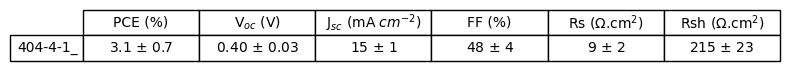

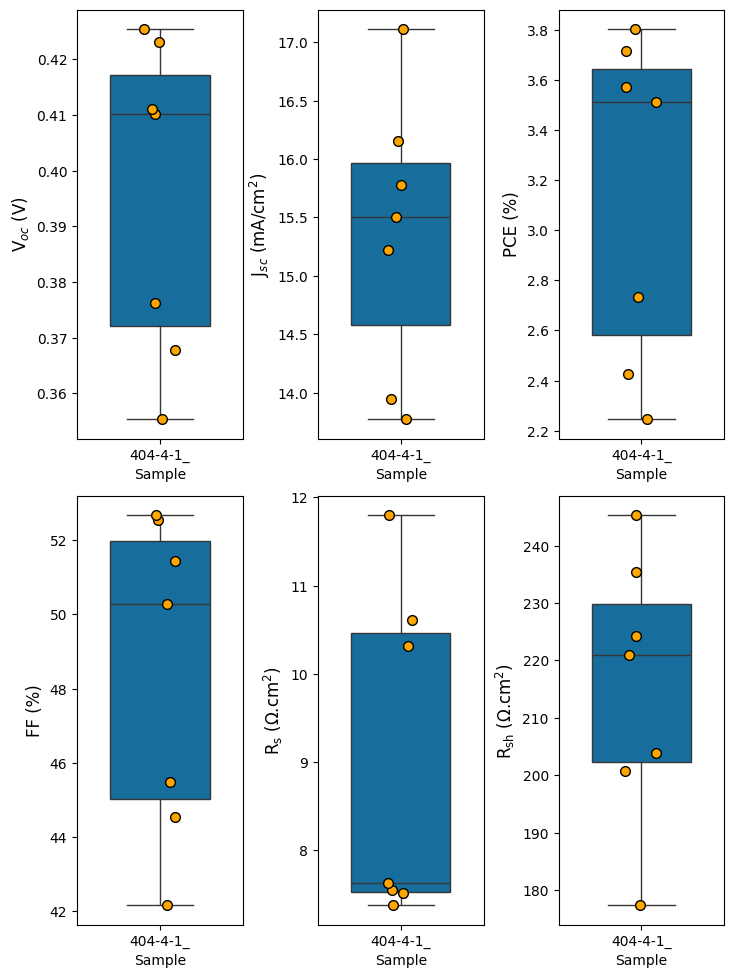

In [20]:
Restable = filter_results_tables(Resfiles)
row_labels = calc_mean_values(Restable) #, False) #Put False if you want to have more decimals in the table
dict_colors = draw_boxplots(Restable, row_labels)#, ['368.3-CdS', '368.1-ZTO 10TTZ', '368.2-ZTO 20TTZ']) #Instead of row_labels, place the order of your samples if you want an specific order

# Best PCE

Cells with best PCE for each sample:


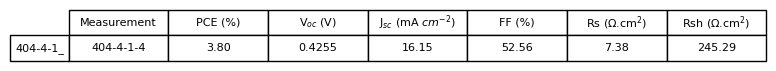

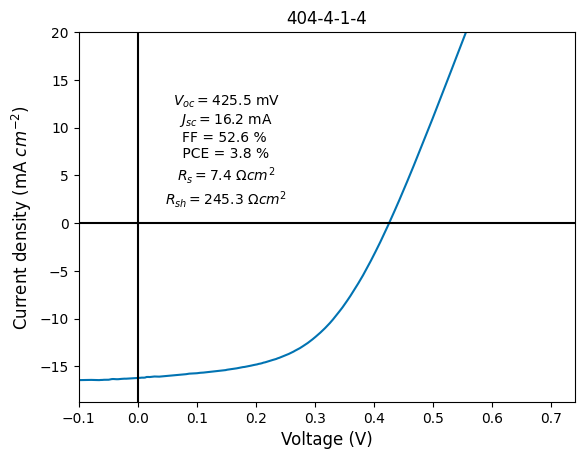

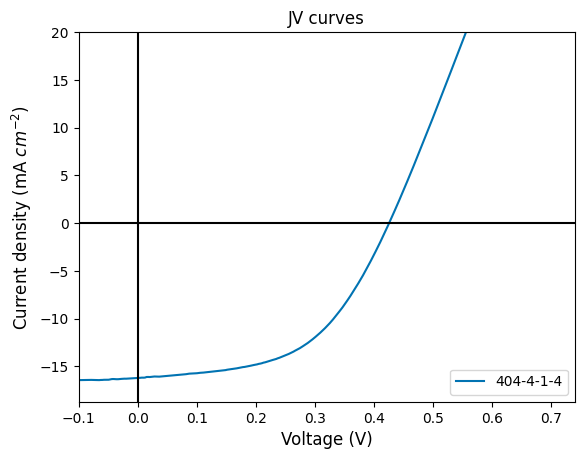

In [21]:
IVtable = read_IV_files(IVfiles)
Bcells = get_best_cell(Restable, 'Efficiency')
plot_JVs(IVtable, Bcells,'PCE', dict_colors)

# Best Voc

Cells with best Voc for each sample:


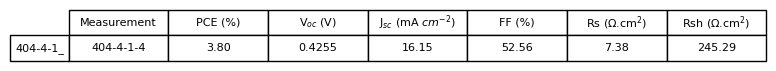

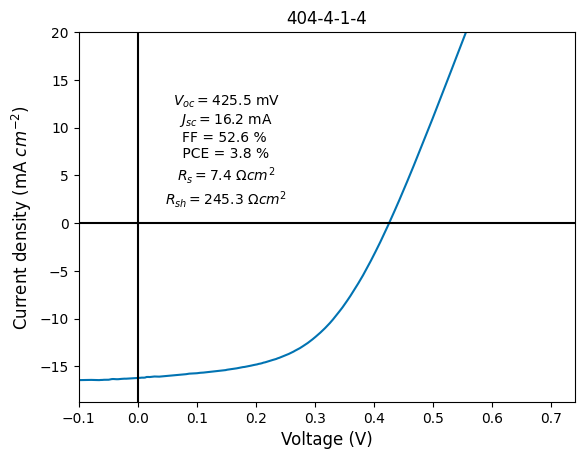

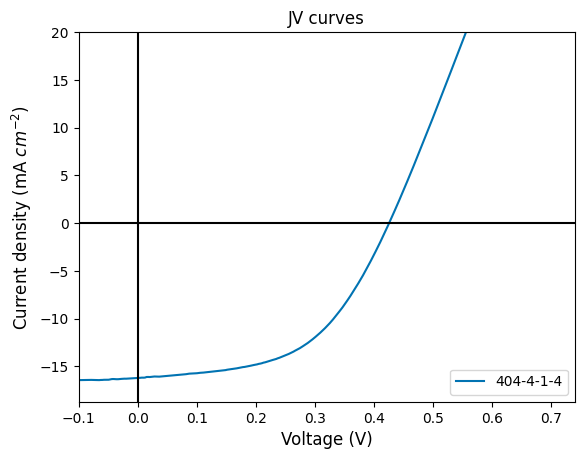

In [22]:
Bcells = get_best_cell(Restable, 'Voc V')
plot_JVs(IVtable,Bcells,'Voc', dict_colors)

# Ideality factor analysis


In order for the program to get the areas from the light curve, the dark curves should have the same name + '_dark' or '-dark'. The code also takes into account the case were both light and dark curves have a suffix that states their type: For example, proper measurement names can be:

*   Sample1_light & Sample1_dark
*   Sample2-light & Sample2-dark
*   Sample3-light & Sample3_dark
*   Sample4_light & Sample4-dark

If you don't use this keywords, you will need to write the area values for each dark curve found in the analyzed files.

In [23]:
# Get "Result Table" files
Resfiles = find_files('*Results Table*.txt')

# Get "IV Graphs" files
IVfiles = find_files('*IV Graph*.txt')

In [24]:
dict_results = get_results_parameters(Resfiles)

What is the area of the sample with name: 404-4-1-1-d 2025-03-14 14-23-55 ? 0.25
What is the area of the sample with name: 404-4-1-2-d 2025-03-14 14-30-20 ? 0.25
What is the area of the sample with name: 404-4-1-3-d 2025-03-14 14-34-42 ? 0.25
What is the area of the sample with name: 404-4-1-4-d 2025-03-14 14-37-18 ? 0.25
What is the area of the sample with name: 404-4-1-5-d 2025-03-14 14-42-24 ? 0.25
What is the area of the sample with name: 404-4-1-6-d 2025-03-14 14-44-35 ? 0.25
What is the area of the sample with name: 404-4-1-7-d 2025-03-14 14-47-07 ? 0.25
What is the area of the sample with name: 404-4-1-8-d 2025-03-14 14-48-54 ? 0.25


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1253: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1246: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1247: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))


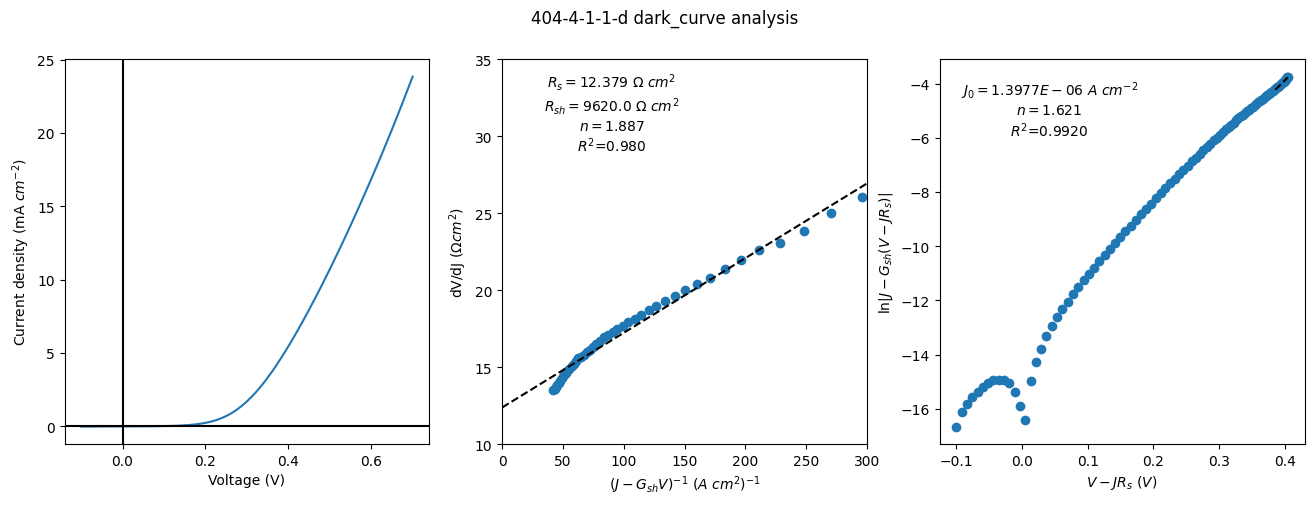

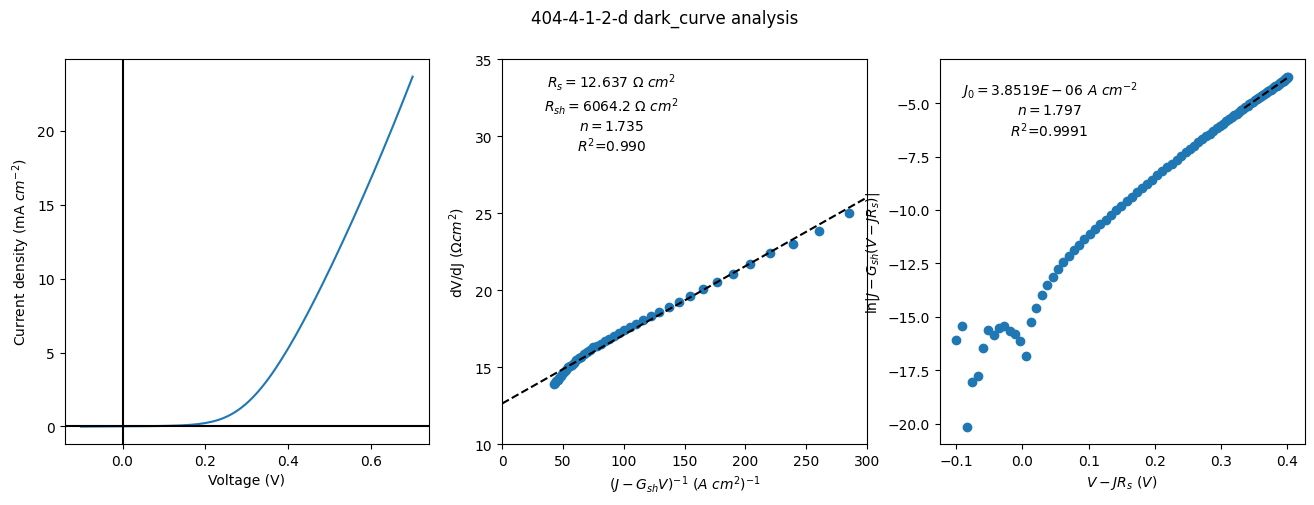

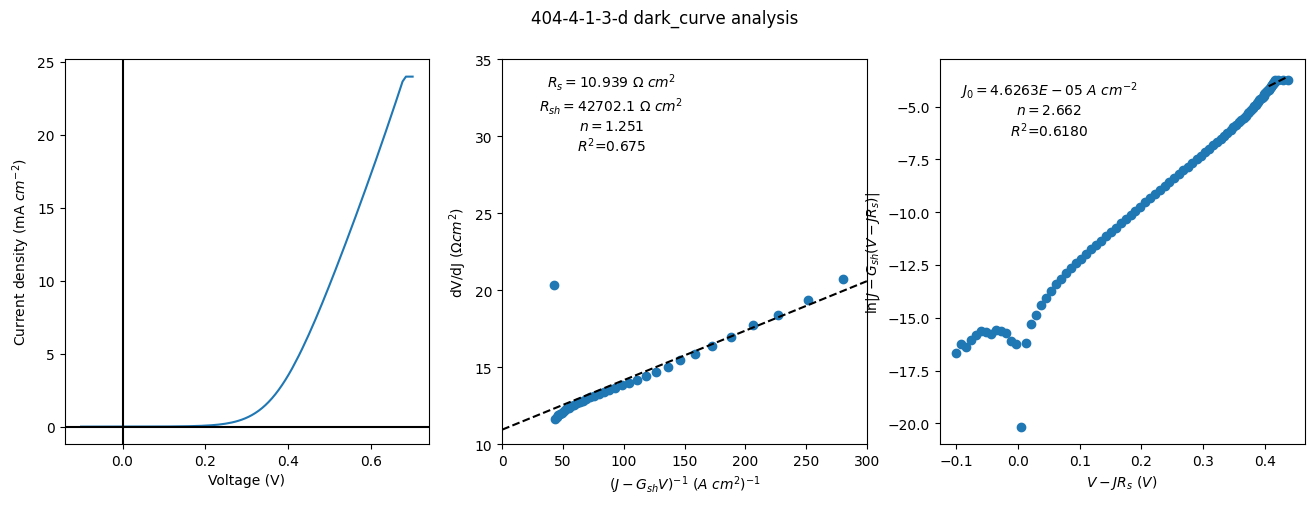

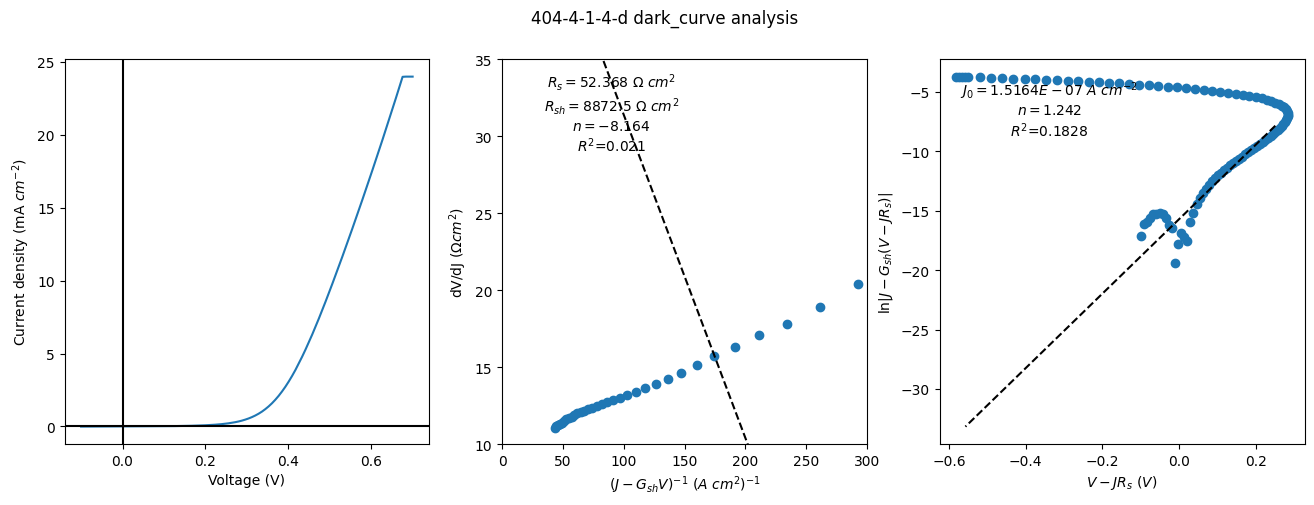

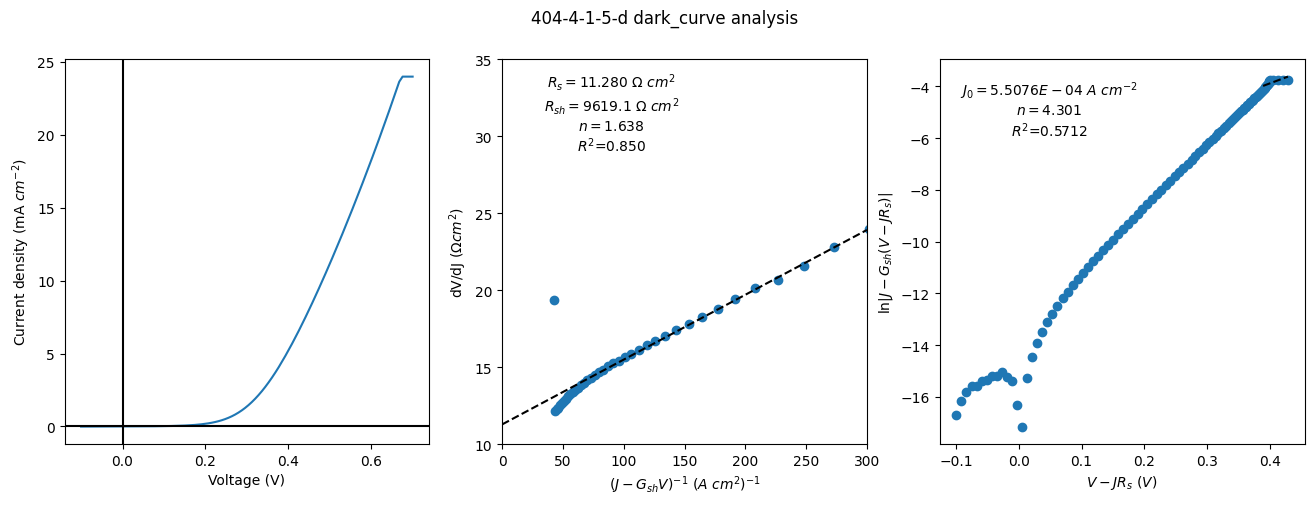

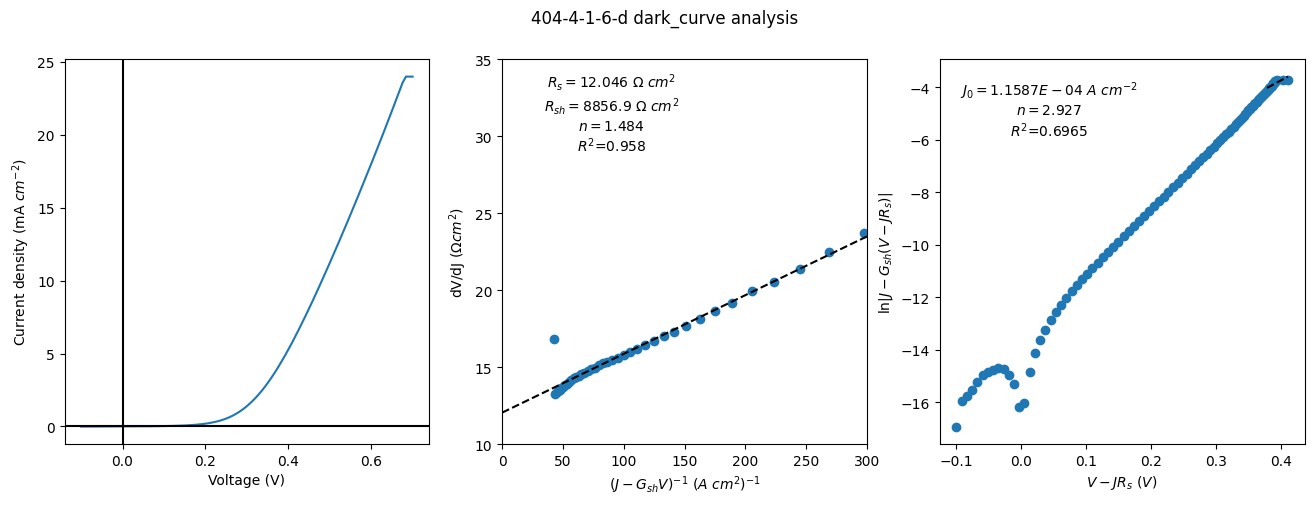

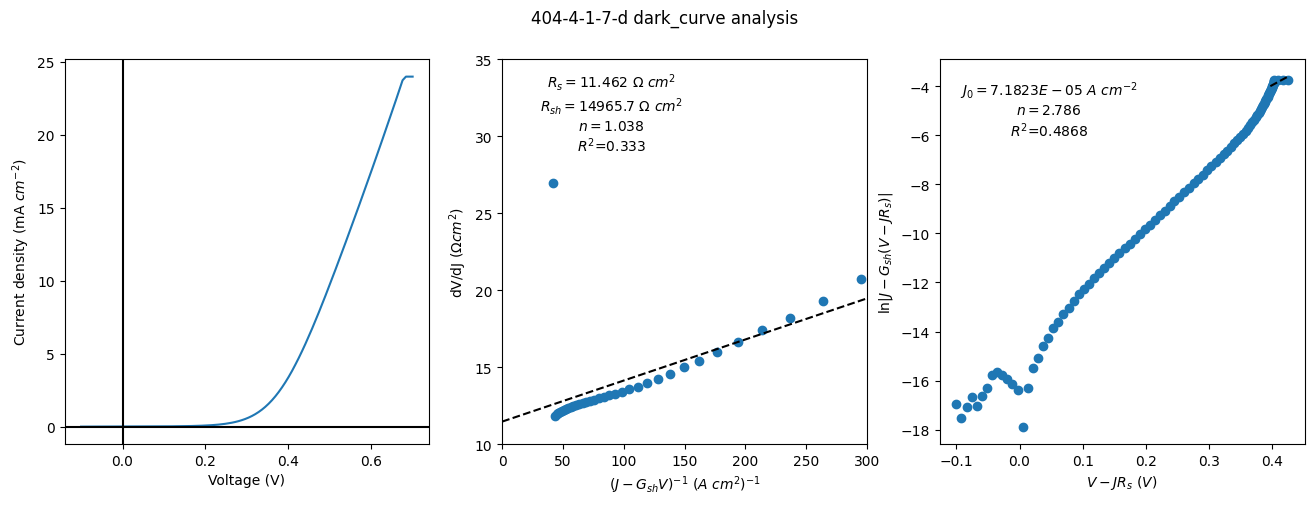

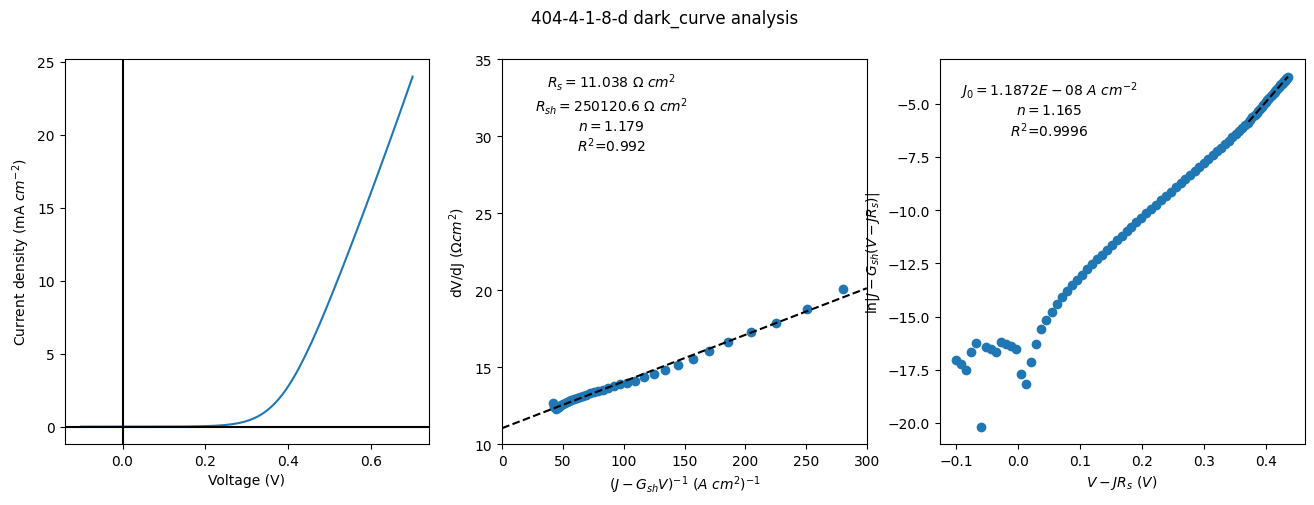

In [25]:
dict_data = dict_results.copy()
data_IV = get_IVdata(IVfiles, dict_data, 'dark')

# Ideality factor (Light curves)

Based on the work of [Zhang et. al.](https://pubs.aip.org/aip/jap/article-abstract/110/6/064504/151473/A-simple-and-efficient-solar-cell-parameter?redirectedFrom=fulltext)

In [106]:
def ideality_factor(Resfiles, JVdata):

  def current_function(v, n, r_s, r_sh, i_sc, v_oc):
    from scipy.special import lambertw

    w = (r_s / (n * Vt)) * (i_sc - ((v_oc)/(r_s+r_sh))) * np.exp( - v_oc/(n * Vt) ) * np.exp( (1/(n*Vt)) * (r_s * i_sc + ((r_sh * v)/(r_sh+r_s))) )

    lw = np.real(lambertw(w))

    I = ((n * Vt)/(r_s)) * lw + v/r_s - i_sc - ((r_sh * v)/(r_s * (r_sh+r_s) ))

    return I

  def helper(v, n, r_s, r_sh):
    return current_function(v, n, r_s, r_sh, I_sc, V_oc)

  df = Resfiles.copy()

  for idx in range(0, Resfiles.shape[0]):
    V_oc = df.iloc[idx]['Voc V']
    I_sc = df.iloc[idx]['Isc A']
    R_s = df.iloc[idx]['R at Voc']
    R_sh = df.iloc[idx]['R at Isc']
    A = df.iloc[idx]['Area cm2']

    data =JVdata
    target_column = df.iloc[idx]['Measurement']
    target_index = data.columns.get_loc(target_column) # Get index of cell

    x_column_index=target_index # Get voltage column index
    y_column_index=x_column_index+1 # Get current column index

    x_col=data.iloc[:,x_column_index] # Get voltage column values
    y_col=data.iloc[:,y_column_index] # Get current column values

    x = np.float64(x_col[1::]) # Skip heading and change to float
    y = -np.float64(y_col[1::]) # Get current skiping heading and change to float

    from scipy.optimize import curve_fit

    popt, pcov = curve_fit(helper, x, y, [1.5, R_s, R_sh])

    n, r_s, r_sh = popt
    dn, dr_s, dr_sh = np.sqrt(np.diag(pcov))
    delta = np.exp( (r_s * I_sc - V_oc)/(n * Vt))

    txt = "$R_s = {0:.3f} \pm {1:.3f}$".format(r_s * A, dn * A) + " $Ω \ cm^2$" + "\n$R_{sh}$" + "$ = {0:.1f} \pm {1:.1f}$".format(r_sh, dr_sh) + " $Ω \ cm^2$" +  "\n$n={0:.3f} \pm {1:.3f}$".format(n, dn) + "\n$\Delta={0:.2e} \ll 1$".format(delta)

    plt.plot(x,y*1000/A, 'o', markerfacecolor='none', markersize=3, alpha=0.7, label='exp. data')
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current density (mA $cm^{-2}$)')
    ylims = plt.gca().get_ylim()
    xlims = plt.gca().get_xlim()
    plt.plot(xlims, [0, 0], 'k', zorder=2)
    plt.plot([0,0], ylims, 'k', zorder=2)
    plt.gca().set_xlim(xlims)
    plt.gca().set_ylim(ylims)

    plt.text(0.4, 0.76, txt, transform=plt.gca().transAxes, horizontalalignment='center')
    plt.title('Measurement : ' + target_column)

    plt.plot(x, helper(x, *popt)*1000/A, 'r--', label='fitting')
    plt.legend()
    plt.show()


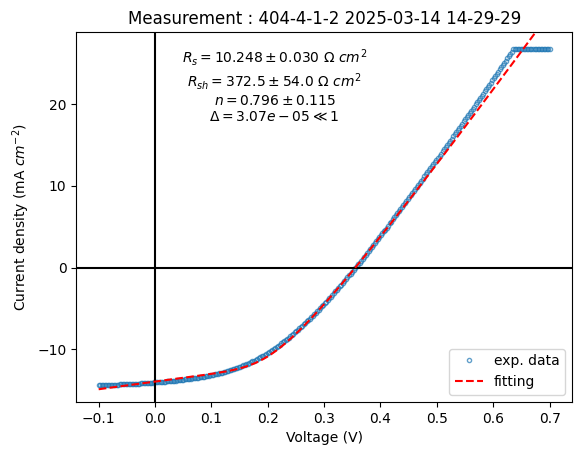

<ipython-input-106-dfd5bd57d3a5>:6: RuntimeWarning: overflow encountered in exp
  w = (r_s / (n * Vt)) * (i_sc - ((v_oc)/(r_s+r_sh))) * np.exp( - v_oc/(n * Vt) ) * np.exp( (1/(n*Vt)) * (r_s * i_sc + ((r_sh * v)/(r_sh+r_s))) )
<ipython-input-106-dfd5bd57d3a5>:6: RuntimeWarning: invalid value encountered in multiply
  w = (r_s / (n * Vt)) * (i_sc - ((v_oc)/(r_s+r_sh))) * np.exp( - v_oc/(n * Vt) ) * np.exp( (1/(n*Vt)) * (r_s * i_sc + ((r_sh * v)/(r_sh+r_s))) )


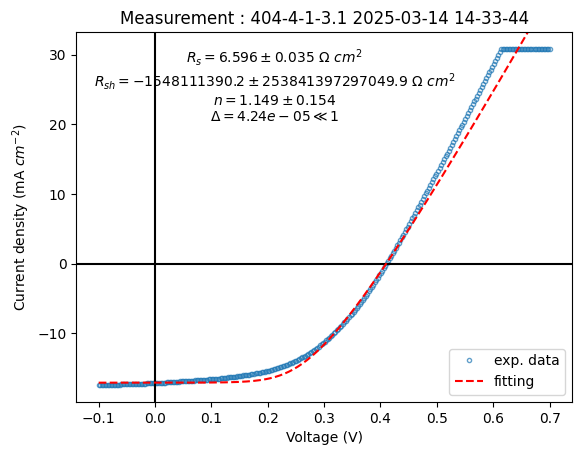

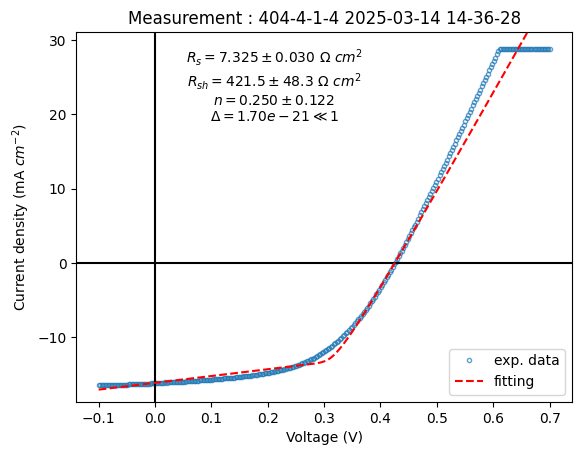

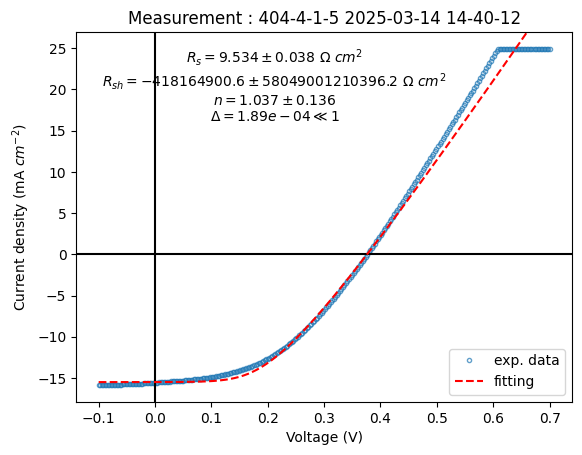

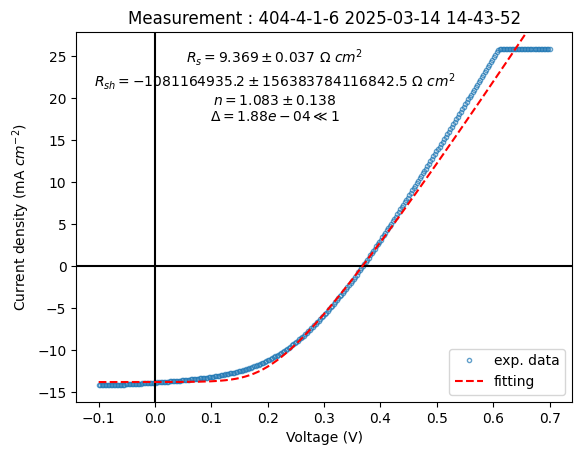

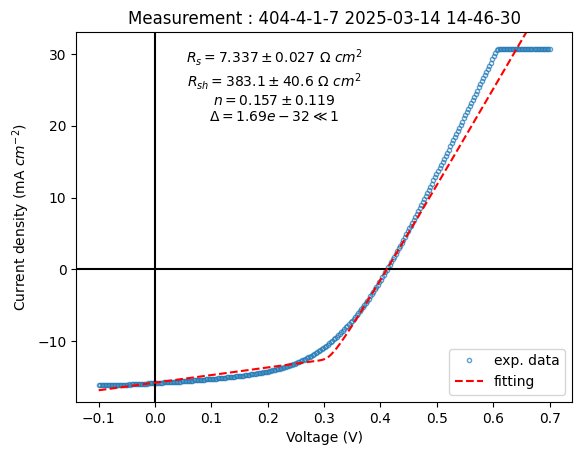

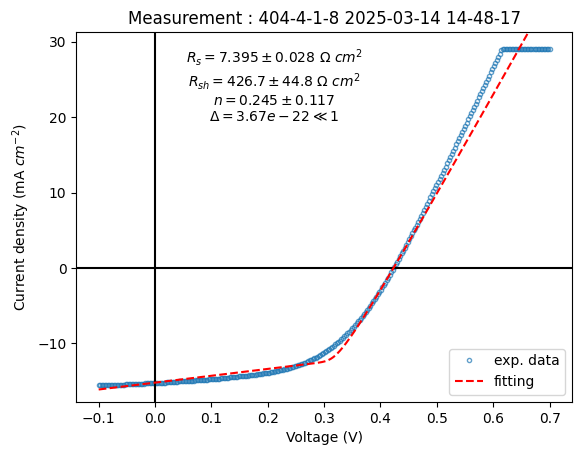

In [107]:
df = filter_results_tables(Resfiles)
JV = read_IV_files(IVfiles)

ideality_factor(df, JV)